# 03: Geoprocessing


## Goals

This notebook will walk through some common geoprocessing tasks using `geopandas`. These operations include:
- reprojecting data
- using a mask to clip data
- performing a spatial join
- performing an attribute join
- dissolving data
- unioning data
- writing functions to calculate new attributes

Together, these operations form the basis of many geospatial analyses. These tools are used to *explore* our datasets and the relationships between them, a common first step in any geospatial analysis.

## Import libraries


In [12]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import geopandas as gpd
from lonboard._map import Map
from lonboard._layer import PolygonLayer
from lonboard.colormap import apply_categorical_cmap

In [13]:
# global map plot settings
plt.rcParams["figure.figsize"] = (10, 10)


# We are doing a lot of plotting, and at the scale we're working, we don't need to see coordinates on the axes.
# We can turn off the axes and ticks by default to keep the plots clean.
# Instead of running this cell, you could add `set_axis_off()` to each plot you create.


def set_axis_off():
    """
    Set the default matplotlib settings to turn off axes and ticks.
    This function modifies the global matplotlib configuration to hide axes and ticks
    for all plots created after this function is called.
    """
    # set axis off by default
    plt.rcParams["axes.axisbelow"] = False
    plt.rcParams["axes.axisbelow"] = False
    plt.rcParams["axes.spines.left"] = False
    plt.rcParams["axes.spines.right"] = False
    plt.rcParams["axes.spines.top"] = False
    plt.rcParams["axes.spines.bottom"] = False

    # set tick params off by default
    plt.rcParams["xtick.bottom"] = False
    plt.rcParams["xtick.top"] = False
    plt.rcParams["xtick.labelbottom"] = False
    plt.rcParams["xtick.labeltop"] = False
    plt.rcParams["ytick.left"] = False
    plt.rcParams["ytick.right"] = False
    plt.rcParams["ytick.labelleft"] = False
    plt.rcParams["ytick.labelright"] = False

Now we can run the function to set the default settings for this notebook.

In [14]:
set_axis_off()

## Import datasets

As you may have noticed in the previous notebook, Pluto is a *huge* dataset that takes a long time to load. In geopandas, you can use the `where=...` argument to load only a subset of the data. This is useful when you want to work with a smaller area or a specific set of features. In this case, we will focus only on tax lots within Brooklyn's community district 7 (`where="CD = 307"`). This will significantly speed up the loading process (and takes out the additional step of filtering the data later).



In [15]:
cb_307 = gpd.read_file(
    "../Data/nyc_mappluto_25v1_1_shp/MapPLUTO.shp"
)

In [32]:
cb_307.columns

Index(['Borough', 'Block', 'Lot', 'CD', 'BCT2020', 'BCTCB2020', 'CT2010',
       'CB2010', 'SchoolDist', 'Council', 'ZipCode', 'FireComp', 'PolicePrct',
       'HealthCent', 'HealthArea', 'Sanitboro', 'SanitDistr', 'SanitSub',
       'Address', 'ZoneDist1', 'ZoneDist2', 'ZoneDist3', 'ZoneDist4',
       'Overlay1', 'Overlay2', 'SPDist1', 'SPDist2', 'SPDist3', 'LtdHeight',
       'SplitZone', 'BldgClass', 'LandUse', 'Easements', 'OwnerType',
       'OwnerName', 'LotArea', 'BldgArea', 'ComArea', 'ResArea', 'OfficeArea',
       'RetailArea', 'GarageArea', 'StrgeArea', 'FactryArea', 'OtherArea',
       'AreaSource', 'NumBldgs', 'NumFloors', 'UnitsRes', 'UnitsTotal',
       'LotFront', 'LotDepth', 'BldgFront', 'BldgDepth', 'Ext', 'ProxCode',
       'IrrLotCode', 'LotType', 'BsmtCode', 'AssessLand', 'AssessTot',
       'ExemptTot', 'YearBuilt', 'YearAlter1', 'YearAlter2', 'HistDist',
       'Landmark', 'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'BoroCode',
       'BBL', 'CondoNo', 'Tract2

To get to know CD 307 a bit better, let's check the distribution of land use types in this community district.

In [16]:
cb_307.LandUse.value_counts()

LandUse
01    566504
02    131336
04     56138
11     24464
05     21207
03     13021
08     12045
06      9385
10      9277
07      6036
09      4740
Name: count, dtype: int64

With this trick, we are able to load only a subset of lots that we are interested in. Next we will load in building foorprints, but that dataset does not have the `CD` attribute to be able to filter by. Instead, we will use a geometric filter based on the bounds of our tax lot geodataframe.

We can get the "total bounds" of our dataset using the `total_bounds` property of the GeoDataFrame.

The "total bounds" is an array of the minimum and maximum x and y coordinates of the geometries in the GeoDataFrame- it is a minimum bounding rectagle for the entire dataset.

In [17]:
# get maximum bounding geometry for all tax lots
bounds = cb_307.total_bounds

Let's visually inspect the bounds of our tax lots.

In [18]:
bounds

array([ 913128.92637062,  120048.98595905, 1067335.95135403,
        272811.18305349])

As an array, this isn't much use to us yet- we need to convert it to a polygon object to be able to use it as a filter. Note that we are also passing the `crs` argument to ensure that the polygon is in the same coordinate reference system as our tax lots (and is aware of that fact).

In [19]:
bounds_poly = gpd.GeoSeries(
    Polygon(
        [
            [bounds[0], bounds[1]],
            [bounds[0], bounds[3]],
            [bounds[2], bounds[3]],
            [bounds[2], bounds[1]],
            [bounds[0], bounds[1]],
        ]
    ),
    crs=cb_307.crs,
)

Now we can see that the bounds are a polygon that covers the entire area of interest.

In [20]:
bounds_poly.explore()

If we plot both datasets together and zoom in, you can see that the bounding polygon *exactly* matches the extent of the tax lots.

<Axes: >

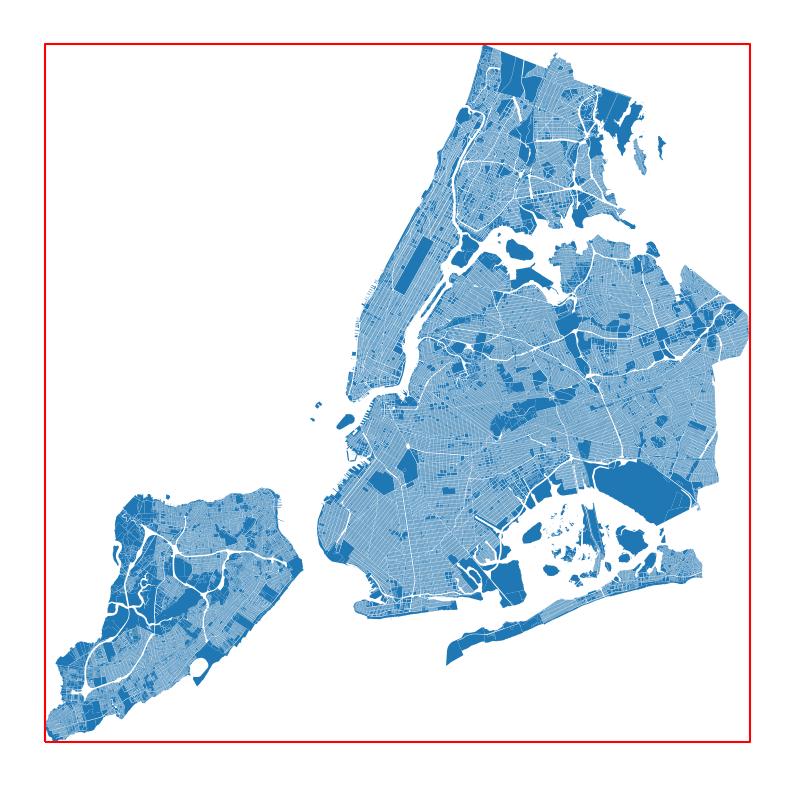

In [21]:
ax = cb_307.plot()
bounds_poly.boundary.plot(ax=ax, color="red")

## Aligning dataset projections


We saw in the previous exercise that the buildings geojson file has a CRS of EPSG:4326, which is WGS84.
Unlike desktop GIS software, GeoPandas does not reproject on-the-fly; as such, we need to explicitly align projections between our datasets to be able to work with them together.

You can check a dataset's CRS (Coordinate Reference System) with the `.crs` attribute. If this returns `None`, the dataset does not have a CRS defined and you can set it with the `.set_crs([crs-here])` method or `[dataset].crs = [crs-here]`.

In [22]:
cb_307.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US survey foot)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [23]:
bounds_poly.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US survey foot)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

To be able to use our bounds polygon to filter the building footprints dataset, we'll need to create a copy of the bounds that are in the right coordinate system. we can create a copy and use the `to_crs()` method to convert into the proper system

In [24]:
bounds_poly_wgs84 = bounds_poly.to_crs("EPSG:4326")

We can confirm that the CRS has changed by checking the CRS attribute again.

In [25]:
bounds_poly_wgs84.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Similar to the *attribute filter* we used previously to only load tax lots in CD 307, we can use a *spatial filter* to only load building footprints that intersect with our bounds polygon using the `mask=...` argument in our input statement.

In [28]:
cb_307_bldgs = gpd.read_file(
    "../Data/BUILDING_20250713.csv",
    mask=bounds_poly_wgs84[0],
)

Now let's visually inpect the buildings in the area of interest.

In [29]:
cb_307_bldgs.plot()

TypeError: no numeric data to plot

So, we are able to successfully read in the building footprints within thd study area and plot them- however, we see that there are also point representations of buildings along with the expected polygon shapes. Let's exclude point type features to be able to work specifically with polygons:

In [ ]:
cb_307_bldgs = cb_307_bldgs[cb_307_bldgs.geometry.type != "Point"]

In [ ]:
cb_307_bldgs.plot()

In [ ]:
cb_307_bldgs = cb_307_bldgs.to_crs(cb_307.crs)

In [ ]:
cb_307_bldgs.plot()

## Combine building footprints and tax lot data


To combine our building footprints with tax lots, we will compare the spatial relations between the two geometries. There are a few quirks to keep in mind:
- in some cases, buildings can cross between tax lots, leaving open the possibility that there are multiple matching tax lots for a single building footprint.
- in other cases, a building footprint may not intersect with any tax lot, such as when a building is on a sidewalk or in a park.

Because of these quirks, we will use a representation of the building footprints that is a *representative point* of the polygon, which is a single point representation of the building footprint. This will allow us to match each building footprint to a single tax lot. 

It's worth mentioning that the buildings *do* have join attributes that we could use to join the two datasets (`mpluto_bbl` and `base_bbl`), but for the purposes of this exercise, we will focus on the spatial join. 


> **Note:**  
> The `representative_point()` method is a way to get a point that is guaranteed to be within the polygon, even if the polygon is complex or has holes. This is useful for matching geometries that may not overlap perfectly. This is a related concept to the `centroid` method, which returns the center point of the polygon, but the representative point is guaranteed to be within the polygon.


To illustrate this point, we'll take a random building footprint using the `sample()` method. We'll look at it's simplified geometry using the `boundary` property, along with the representative point of the polygon.

In [ ]:
ss = cb_307_bldgs.sample()

ax = ss.boundary.plot()
ss.representative_point().plot(ax=ax)

Okay, now that we understand the concept of representative points, let's generate one for each building footprint in our dataset. We'll then set this column as the geometry of the GeoDataFrame so that we can use it for spatial operations (while still keeping the original geometry for reference).

In [ ]:
cb_307_bldgs["rep_pt"] = cb_307_bldgs.representative_point()
cb_307_bldgs.set_geometry("rep_pt", inplace=True)

Let's take a look- we can see *two* geometry columns now, one for the original building footprint and one for the representative point.

In [ ]:
cb_307_bldgs.head()

Of course, there are plenty of cases where there are multiple buildings on a single tax lot. We can compare the number of unique tax lot ids with the number of buildings / building IDs to get a sense of this relationshp: 

In [ ]:
print(
    f"There are {cb_307_bldgs.base_bbl.nunique()} unique base BBLs in Community Board 307, \nalong with {cb_307_bldgs.shape[0]} total buildings and {cb_307_bldgs.globalid.nunique()} unique building IDs."
)

## Perform spatial join

Now we will use the spatial join operation to join the building footprints to the tax lots based on the relationship between the representative points and lot polygons. The spatial join is a fundamental operation in GIS that allows us to combine attributes from two different datasets based on their spatial relationship. Read more about geopandas' implementation of spatial joins in the [documentation](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.sjoin.html#geopandas.GeoDataFrame.sjoin), and note that some of the directives have changed between recent versions.

Here we take a subset of attributes of the buildings layer, denoted in the double brackets `[[...]]` and use the `sjoin()` method to join to the tax lots layer.

We are performing an `inner` join, matching overlapping features between the two datasets, vs. an `outer`, `right`, or `left` join. We are also using the spatial predicate `within` to specify what kind of spatial relationship we want to use as the basis of the join.

In [ ]:
## spatial join buildings to tax lots based on building representative point
bldgs_w_lot = cb_307_bldgs[["globalid", "mpluto_bbl", "rep_pt"]].sjoin(
    cb_307, how="inner", predicate="within"
)

In [ ]:
bldgs_w_lot.head()

Let's try a different approach- we can use a similar function, `sjoin_nearest()` to join features to the nearest feature in the target dataset. In this example, we are performing a `left` join, which means we are keeping all features in the input dataset, but we need to keep in mind that there may be cases where multiple input features are closest to a target (tax lot) feature. There's an optional argument for the function, `exclusive` which defaults to `False`, which would allow us to prevent duplicate matches.

We will pass in an additional optional argument, `distance_col`, which will calculate and record the distance from our input features from the matching target feature. This is important as we explore the spatial relationship between our datasets.

In [ ]:
bldgs_w_lot_nearest = cb_307_bldgs[["globalid", "mpluto_bbl", "rep_pt"]].sjoin_nearest(
    cb_307, how="left", distance_col="distance"
)

We can plot the distance field to visualize how far each input feature is from a target feature. What do you notice?

In [ ]:
bldgs_w_lot_nearest.plot("distance", legend=True)

Now let's visualize our building points on top of our tax lots

In [ ]:
ax = cb_307.plot(color="#ababab")
bldgs_w_lot.plot(ax=ax, color="red", alpha=0.5)

### Merge back with footprints

Now that we've associated each tax lot with every building's representative point, we can merge back with the input footprint geometry to be able to represent the data using footprints.

In the below example, we are chaining a few different operations together:
- using the `drop()` function to get rid of the `rep_pt` column, which we no longer need
- using the `merge()` function to merge the data we *do* want to keep with our previous building footprints dataset, making sure to only keep the building footprints with matches (based on the `left` directive)

In [ ]:
# now, join back to original building footprints
bldgs_w_lot = bldgs_w_lot.drop(columns=["rep_pt"]).merge(
    cb_307_bldgs, on="globalid", how="left"
)

We need to cast our new dataset explicitly as a geodataframe for geopandas to be able to recognize that `geometry` is a special column.

In [ ]:
bldgs_w_lot_gdf = gpd.GeoDataFrame(bldgs_w_lot, geometry="geometry")

In [ ]:
bldgs_w_lot_gdf.plot()

... and we'll borrow the colormap we created in the first notebook here to be able to produce a consistent representation of land uses on a per-lot and building basis

In [ ]:
cmap = {
    "One & Two Family Buildings": "#ffff00",
    "Multi-Family Walk-Up Buildings": "#fffb00",
    "Multi-Family Elevator Buildings": "#ffc800",
    "Mixed Residential & Commercial Buildings": "#ff4000",
    "Commercial & Office Buildings": "#ff0000",
    "Industrial & Manufacturing": "#7700ff",
    "Transportation & Utility": "#808080",
    "Public Facilities & Institutions": "#001580",
    "Open Space & Outdoor Recreation": "#219F21",
    "Parking Facilities": "#A6A6AB",
    "Vacant Land": "#222222",
    "Unknown": "#000000",
}

Similarly, we will convert the hex code-based cmap to the RGB-type representation that `lonboard` needs for visualizing

In [ ]:
cmap_rgb = {k: list(int(v[i : i + 2], 16) for i in (1, 3, 5)) for k, v in cmap.items()}

In [ ]:
bldgs_w_lot_gdf["LandUse"].fillna("Unknown", inplace=True)

Let's visually inspect the relationships between land use and color columns just to make sure things are mapped properly.

In [ ]:
bldgs_w_lot_gdf[["color", "LandUse"]].sample(10)

Now let's use `lonboard` to plot the output in 3D. we should be able to see each building shaded in the color that represents a land use based off it's spatial relationship with tax lots from the previous steps. Because each building footprint has an estimated height field (`heightroof`), we can use that as the extrude height for each feature. 

In [ ]:
# make a lonboard plot with color based on land use and height based on number of floors
heights = bldgs_w_lot_gdf["heightroof"].astype(float).to_numpy()
bldgs_layer = PolygonLayer.from_geopandas(
    bldgs_w_lot_gdf[["geometry", "LandUse"]].to_crs("EPSG:4326"),
    get_fill_color=apply_categorical_cmap(bldgs_w_lot_gdf["LandUse"], cmap=cmap_rgb),
    extruded=True,
    get_elevation=heights,
)

m = Map(
    [bldgs_layer],
    view_state={
        "pitch": 45,
        "zoom": 14,
        "latitude": 40.6459406,
        "longitude": -74.0151512,
    },
)
m

Across the above steps, we've witnessed how the spatial relationships between different datasets can be messy- items can overlap with multiple features, or not overlap with any features! At every step, we need to investigate how and to what degree our data matches. Thankfully, as we saw above, these datasets *do* share an attribute that can be used to connect: the `bbl` identifier, which stands for **b**orough **b**lock **l**ot.

We will use this shared attribute as the basis for a join in the next steps.

## Performing attribute joins


Remember that we brought in the building footprints layer based on a mask, and that the building footprints' extent exceeds that of the community district we are interested in. We can confirm this by looking at the number of unique `mpluto_bbl` entries vs the number of records in our `cb_307` dataset.

In [ ]:
cb_307_bldgs.mpluto_bbl.nunique(), cb_307.shape[0]

Before we merge, together, we need to confirm that the `BBL`s are encoded as the same data type- as we see below, the building footprints dataset encodes the BBLs as `O` or objects (i.e. as strings) and the tax lot dataset encodes them as `float64` numbers. We'll need to convert one or the other to be able to join them together

In [ ]:
cb_307_bldgs.mpluto_bbl.dtype, cb_307.BBL.dtype

We can convert the building `mpluto_bbl` field as floats to match the tax lot dataset. We could just as easily go in the opposite direction and convert the tax lot dataset to objects instead (e.g. `...astype(str)`)

In [ ]:
cb_307_bldgs["mpluto_bbl"] = cb_307_bldgs["mpluto_bbl"].astype(float)

Now we can merge the datasets together- in cases where the join field is not the same, you have to specify `left_on=...` and `right_on=...` instead of just `on=...`. Since we are only interested in cases where the records overlap (i.e. in CB 307), we will do an `inner` join. In this particular case, that's the same as doing a `right` join.

We will also use the `suffixes` attribute to properly name fields that exist in both datasets to not get confused later. (The default behavior is to append `_x` and `_y` to matching columns).

In [ ]:
bldgs_w_lot_attrib = cb_307_bldgs.merge(
    cb_307,
    left_on="mpluto_bbl",
    right_on="BBL",
    how="inner",
    suffixes=["_bldg", "_lot"],
)

In [ ]:
bldgs_w_lot_attrib.head()

As you can see, joining based on attributes can be a more straightforward process than the various operations we had to conduct for the spatial join. Now we can compare these results against our previous spatial join results. At a high level, we can see (in the next cell) that the dataframes are not the same length, meaning that at some point, certain features are dropped (or not) in different ways between the different datasets. What do you think those points of difference are?

In [ ]:
bldgs_w_lot_attrib.shape[0] == bldgs_w_lot_gdf.shape[0]

They don't match! How close are they?

In [ ]:
print(
    f"There are {bldgs_w_lot_attrib.shape[0]} features in the attribute join dataset\nand {bldgs_w_lot_gdf.shape[0]} features in the spatial join dataset"
)

Not bad- but there are three buildings that our spatial join did not pick up that our attribute join *did*. Let's investigate.

Let's compare the two datasets. Below we'll plot the longer, more complete list of buildings generated through the attribute join vs. the buildings that *do not* match between the two. We will use the selection logic in square brackets to perform this selection.


We are selecting *from* the dataset using the conditions in the square brackets. The `~` operator means *not*- so we are selecting the reverse of the following statement: `bldgs_w_lot_attrib.globalid.isin(bldgs_w_lot_gdf.globalid)`. This statement looks for cases where the global building id from the attribute join `bldgs_w_lot_attrib` dataset is in the list of the spatial join dataset's (`bldgs_w_lot_gdf`) global ids. Because we start this filter off with the `~`, we are asking for cases where IDs are in the attribute join dataset, but not the spatial join dataset.

Filter statements like this can be written in a number of different ways, so be sure to mind each part of the statement as you construct your filter.

In [ ]:
# find the globalid of the buildings in bldgs_w_lot_attrib that are not in bldgs_w_lot_gdf
ax = bldgs_w_lot_attrib.plot()
bldgs_w_lot_attrib[~bldgs_w_lot_attrib.globalid.isin(bldgs_w_lot_gdf.globalid)].plot(
    ax=ax, color="red"
)

Now let's look at the inverse and create a new dataframe which includes *only* the three missing buildings. We'll use a similar selection logic as before. We'll then confirm that there are three missing buildings in our dataframe.

In [ ]:
missing_buildings = bldgs_w_lot_attrib[
    ~bldgs_w_lot_attrib.globalid.isin(bldgs_w_lot_gdf.globalid)
].copy()

In [ ]:
missing_buildings.shape[0]

To be able to visually inspect those missing buildings against our other joined buildings, we'll have to clean up our joined dataset: because both the lot and the building dataset contained `geometry` fields, we now have `geometry_lot` and `geometry_bldg`. We need to clarify which we want to use. We have a few options:
- we can create a new column named `geometry` and set it to the value of `geometry_bldg`, and then set the geodataframe's geometry column to that using `set_geometry`
- we can just set the geometry column to be `geometry_bldg`. 

There is no right or wrong choice here- for the sake of brevity we'll directly set the geometry column. 

In [ ]:
bldgs_w_lot_attrib.set_geometry("geometry_bldg", inplace=True)

In [ ]:
missing_buildings.set_geometry("geometry_bldg", inplace=True)

### Map the missing buildings


Map the missing buildings and zoom around to find where they are and what kind of spatial relationship(s) they have with the tax lot dataset.

In [ ]:
# make a lonboard plot with color based on land use and height based on number of floors

heights_missing = missing_buildings["heightroof"].astype(float).to_numpy()

lots_layer = PolygonLayer.from_geopandas(
    cb_307[["geometry", "LandUse"]].to_crs("EPSG:4326"),
    get_fill_color=[240, 240, 240, 155],
)

missing_bldgs_layer = PolygonLayer.from_geopandas(
    missing_buildings[["geometry_bldg", "LandUse"]].to_crs("EPSG:4326"),
    get_fill_color=[255, 0, 0, 155],
    extruded=True,
    get_elevation=heights_missing,
)

m = Map(
    [missing_bldgs_layer, lots_layer],
    view_state={
        "pitch": 45,
        "zoom": 14,
        "latitude": 40.6459658,
        "longitude": -74.0151512,
    },
)
# actually show the map
m

So we can see that there are three cases where buildings are associated with lots, even if their representative point (or entire geometry) fall outside of the actual polygon.


## Dissolve


A common geoprocessing operation is to *dissolve* features based on a shared attribute. This is useful when you want to aggregate data to a higher level of geography, such as aggregating tax lots to blocks or neighborhoods, or based on a shared attribute. This is similar to the `groupby()` function in pandas, but it also merges the geometries of the features that are being grouped together.


In this case, we will dissolve lots based on the `OwnerName` field: we will merge all lots that share the same owner into a single polygon. This is useful for understanding the extent of land owned by a particular entity.

You can read more about the `dissolve()` function in the [geopandas documentation](https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html).

At the most basic level, you can dissolve all the geometry together into a single feature by not passing any arguments to the `dissolve()` function- however, this may not be very useful on its own. You can pass the `by=...` argument to specify which attribute to dissolve by (very similar to the `groupby()` function in pandas). 

You can also specify how you want to treat other attributes in the dataset using the `aggfunc=...` argument. By default, this is set to `first`, which means that for each group of features being dissolved, the first value of each attribute will be kept. You can also use other aggregation functions such as `sum`, `mean`, `min`, `max`, etc. You can also pass a dictionary to specify different aggregation functions for different attributes. In the below example, we will pass a dictionary with two entries:
- we want to get a `list` of all of the different `LandUse` types for each owner (what kinds of land do they own?)
- we want to get the `sum` of the `LotArea` field for each owner (how much land do they own in total?)

Finally, we use the `as_index=False` argument to ensure that the `OwnerName` field is kept as a column in the output dataframe, rather than being set as the index. We could instead use `reset_index()` after the dissolve operation to achieve the same effect.

In [ ]:
cb_307_by_owner = cb_307.dissolve(
    by="OwnerName",
    aggfunc={
        "LandUse": list,
        "LotArea": "sum",
    },
    as_index=False,
)

Let's take a look at the top ten owners with the greatest total lot area.

In [ ]:
cb_307_by_owner.sort_values("LotArea", ascending=False).head(10)

And now let's map the results using the `OwnerName` field to color the dissolved polygons.

In [ ]:
fig, ax = plt.subplots()
cb_307.plot(color="#cecece", ax=ax, alpha=0.5)

cb_307_by_owner.sort_values("LotArea", ascending=False).head(10).plot(
    column="OwnerName", legend=True, ax=ax
)

# get legend item
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.5, 0.0, 0.5, 0.2))
ax.set_title("Top 10 Owners by Lot Area")

Take a look at the results- what do you notice? It's clear from the above that the results are limited by the availability of complete data.

## Intersect / Difference


Next we'll perform additional geometric operations to identify the portions of tax lots that are not covered by buildings. This workflow demonstrates how to create a new dataset based on existing inputs.

To begin, we'll choose a random block within CB 307.

In [ ]:
sample_block = cb_307.Block.sample(1).values[0]

Now we'll select the blocks and building footprints that match the randomly selected block, and will create new dataframes for each.

In [ ]:
sample_block_lots = cb_307[cb_307.Block.eq(sample_block)].copy()
sample_block_bldgs = cb_307_bldgs[
    cb_307_bldgs.mpluto_bbl.isin(sample_block_lots.BBL.unique())
].copy()

In [ ]:
sample_block_bldgs.set_geometry("geometry", inplace=True)

We can plot those to visually inspect the sampled block, lots, and building footprints.

In [ ]:
ax = sample_block_lots.boundary.plot(color="black", linewidth=0.5)
sample_block_bldgs.plot(ax=ax, color="red")

ax.set_title(f"Block {sample_block}")

Next we can identify the portions of the block that are *not* buildings by calculating the `difference` between the lots and the buildings. We will use the `unary_union` property of the buildings dataframe, which represents a [union of all geometries in the dataframe](https://geopandas.org/en/v0.10.0/docs/reference/api/geopandas.GeoSeries.unary_union.html). It is essentially a shortcut to a dissolve of all geometries in a dataframe. 

With these chained commands, we will return the area of each tax lot that is not a building.

In [ ]:
sample_block_non_bldg = sample_block_lots.difference(sample_block_bldgs.unary_union)

We can plot the results to confirm that each lot still exists as its own feature (blue with black outlines) and are separate from the orange building polygons. Note that in some cases, lots may be split into two distinct areas, making them *MultiPolygons*.

In [ ]:
ax = sample_block_non_bldg.boundary.plot(color="black", linewidth=0.5)
sample_block_non_bldg.plot(ax=ax)
sample_block_bldgs.plot(ax=ax, color="orange")

We could use this new dataset to calculate the *lot coverage* of each lot, which could be useful in a soft site analysis (continued below). Next we will explore another means of calculating lot coverage by *unioning* features instead of taking the intersection.

## Union


We'll continue using the sample block we identified above. We'll start by calculating the lot area of each lot in our sample.

In [ ]:
sample_block_lots["lot_area"] = sample_block_lots.area

Now we'll perform a *union* between the lots and the building footprints. A union, like the *difference* performed above, is a kind of *overlay* method that we can apply between multiple dataframes. (For more information on other overlay methods, check out [the documentation](https://geopandas.org/en/v0.10.0/docs/user_guide/set_operations.html)). The `union` operation retains all geometry of the input layers, as well as the attributes of each based on the overlap. 


<img src="https://geopandas.org/en/v0.10.0/_images/overlay_operations.png" alt="Geopandas overlay operations" width="600"/>

*Source: QGIS Documentation via Geopandas docs*

A union would take the following input:

<img src="https://geopandas.org/en/v0.10.0/_images/overlay_example.png" alt="Geopandas overlay operations" width="600"/>

and produce the following output: 

<img src="https://geopandas.org/en/v0.10.0/_images/overlay_example_union.png" alt="Geopandas overlay operations" width="600"/>


In [ ]:
lots_bldgs_union = gpd.overlay(sample_block_lots, sample_block_bldgs, how="union")

A union will produce features that have geometry entries (based on the union operation), as well as attributes from both input datasets *so long as there is coverage of that dataset*. In our example, there will be full attributes of both datasets for the portion of the lots that are buildings, but the other portions of lots will not have attributes from the buildings dataset. 

In [ ]:
lots_bldgs_union.head()

We can illustrate that point by mapping the output layer. In the below example, we filter for cases where the `globalid` (which is associated with the buildings dataset) is null (`.isna()`) in grey. Cases where the `globalid` is *not* null are red.

In [ ]:
ax = lots_bldgs_union[lots_bldgs_union.globalid.isna()].plot(color="#cecece")
lots_bldgs_union[lots_bldgs_union.globalid.notna()].plot(ax=ax, color="red")

We can also plot based on a shared attribute to demonstrate that both portions of the lots (building and non-building) are part of the same lot. Plotting the boundary separately confirms that each segment of the building/lot combination is in fact a separate feature.

In [ ]:
ax = lots_bldgs_union[lots_bldgs_union.globalid.isna()].plot("Lot")
lots_bldgs_union[lots_bldgs_union.globalid.notna()].plot("Lot", ax=ax)
lots_bldgs_union.boundary.plot(color="black", ax=ax, linewidth=0.5)

Finally, we can create a new attribute field that represents the *percent of the lot that is covered by a building* as discussed above. The below operation uses a *lambda* function, which is a way to iterate through a dataframe and perform a calculation on each row (or column, based on the `axis=...` argument). The function can be understood as follows:
- `lambda x: ... axis=1` for each row (`x`, based on the `1` axis value), perform the following operation
- `((x.geometry.area / x.lot_area)*100...)`: take the geometry of each piece of the unioned dataframe, calculate the area, divide it by the lot area (which we calculated above, pre-union), and multiply by 100 to get a percentage
- `if type(x.globalid) == str else -1`: only do this for the input features that are pieces of buildings (e.g. they have a `globalid`), otherwise return a placeholder value of `-1`. This number is negative on purpose so it is easy to filter out, but you could also use `None` or `NaN` if you prefer.

As you can see, we can perform a multi-step operation using a `lambda` function. For more complex operations, it makes sense to write standalone functions for legibility- we'll demonstrate that in the following section. There is no hard rule for legibility vs. brevity (i.e. lambda vs standalone functions), so use your best judgement. What's important is that you or your user understand what the code is doing.

In [ ]:
lots_bldgs_union["pct_bldg_lot_coverage"] = lots_bldgs_union.apply(
    lambda x: ((x.geometry.area / x.lot_area) * 100 if type(x.globalid) == str else -1),
    axis=1,
)

Now let's plot and see the percentage of each lot that is covered by buildings. This could be expressed in a number of different ways (e.g. at the lot level) but we can get a sense of the utility of the `union` operation.

In [ ]:
lots_bldgs_union.plot("pct_bldg_lot_coverage", legend=True)

## Creating new attributes


In this example, we'll develop a function that indicates whether a site is a "soft site" or not. A "soft site" is a site that meets certain criteria for redevelopment. The factors below represent just a few of the considerations that are often taken to determine whether a site may be a good candidate for redevelopment, but this is a simplistic example case to illustrate a point rather than a firm ruleset.

Because we are considering a few different factors, we will write a new *function* vs. chaining criteria together in a `lambda` function (although you could use the same kind of syntax above to perform the same work). 

There are several important components to consider.

`def [function_name]([input_args...]):` 
The instantiation of the function is important. We are *defining* (`def`) a new function, giving it a name (in this case, `is_soft_site`), and indicating that there are two possible input arguments: `r`, which is a common shorthand for a row in a dataset, and the optional argument `threshold`. This is *optional* and comes with a default value of `0.33`, meaning that if a user doesn't specify a threshold, `0.33` will be used. You could imagine other cases where required or optional arguments might be useful!

`if (...): return 1 else: return 0`
This is the part of the function that is evaluating properties of our input `r` based on it's properties. We can see the evaluation of its `BuiltFAR` compared to the lot's `ResidFAR` (allowed residential FAR) times the `threshold` set here. We are determining whether the site is built less than or equal to 33% of the allowable residential FAR. 

We then evaluate the lot area, existing land use, and whether there is available residential FAR at all to indicate that yes, this is a soft site, or no, it is not. The `return` statements are what pass that information back to us: if those conditions are met, we get a `1`, otherwise a `0`.

Functions don't necessarily have to return anything, but in this case we will be using this logic to create a new field and so want to be sure that *something* is always returned.

In [ ]:
def is_soft_site(r, threshold=0.33):
    if (
        r.BuiltFAR <= r.ResidFAR * threshold
        and r.LotArea > 10000
        and r.LandUse != "Open Space & Outdoor Recreation"
        and r.ResidFAR > 0
    ):
        return 1
    else:
        return 0

We can invoke the function using the `apply()` method- here we pass in the function name, and specify that we want to apply the function to each *row* (`axis=1`) vs each *column* (`axis=0`) of our table. 

If we wanted to pass in a `threshold` value, we could pass in a tuple of arguments: `...apply(is_soft_site, axis=1, args=(0.5,))` which is then passed in as a different threshold. Part of the point of providing these optional attributes is to make it easier for you / your users to make changes quickly- in a more complex example you might also have arguments for your lot area thresholds, the land uses that are off limits, etc.

In [ ]:
cb_307["soft_site"] = cb_307.apply(is_soft_site, axis=1)

Now let's check how many soft sites we have in the neighborhood based on the criteria we defined above. Because we use 1/0 values to distinguish soft sites from not, we can use the `value_counts()` method to get a quick overview of the number of soft sites in the neighborhood.

In [ ]:
cb_307["soft_site"].value_counts()

Now let's create a quick map to see where our soft sites are. What do you notice about the distribution of sites?

In [ ]:
ax = cb_307.plot(color="#cecece", alpha=0.5)
cb_307[cb_307.soft_site > 0].plot("soft_site", ax=ax, legend=True, categorical=True)
plt.title("Soft Sites in Community Board 307")

In [ ]:
cb_307[cb_307.soft_site.eq(1)][["soft_site", "BuiltFAR", "ResidFAR"]]

In [ ]:
# map soft sites
soft_sites = cb_307[cb_307.soft_site.eq(1)].copy().to_crs("EPSG:4326")
soft_sites["ResidFAR"]

lots_layer = PolygonLayer.from_geopandas(
    soft_sites[["geometry", "ResidFAR"]],
    extruded=True,
    get_elevation=soft_sites["ResidFAR"] * 15,  # scale elevation for visibility
    pickable=True,
)

base_layer = PolygonLayer.from_geopandas(
    cb_307[["geometry", "LandUse"]].to_crs("EPSG:4326"),
    get_fill_color=[200, 200, 200, 155],
)

m = Map(
    [base_layer, lots_layer],
    view_state={
        "pitch": 45,
        "zoom": 14,
        "latitude": 40.6459406,
        "longitude": -74.0151512,
    },
)
m